    In this workbook, we will investigate the PGE raw data collected in the S3 bucket of the PGE project. The goal of this exploration is to determine what data we have, and explore the relationships in the data
    
    https://dluo.me/s3databoto3
 

First, we setup the environment

In [1]:
import os #environment variables
import boto3 #aws toolkit
import pandas as pd #data analytics toolkit
import json #json tools
import matplotlib.pyplot as plt #plotting
import seaborn as sns #plotting
import io

In [2]:
# are the environment variables currently set?
#print(os.environ)
#print(os.environ['AWS_SECRET_ACCESS_KEY'])
#print(os.environ['AWS_ACCESS_KEY_ID'])

In [3]:
#https://wiki.python.org/moin/ConfigParserExamples
from configparser import ConfigParser
def config(filename='s3_2.ini',section='awsS3'):
    parser = ConfigParser()
    parser.read(filename)
    os.environ["AWS_ACCESS_KEY_ID"] = parser.get('awsS3','AWS_ACCESS_KEY_ID')
    os.environ["AWS_SECRET_ACCESS_KEY"] = parser.get('awsS3','AWS_SECRET_ACCESS_KEY')
    print('S3 environment variables loaded')
    #print(parser.get('awsS3','AWS_ACCESS_KEY_ID'))
    #print(parser.get('awsS3','AWS_SECRET_ACCESS_KEY'))
    

In [4]:
#adding user keys to access the s3 bucket. See IAM on AWS for more information
#if you have the config file, run the config function here
config()
#if you dont have a s3.ini file, manually enter the environment variables here
#os.environ["AWS_ACCESS_KEY_ID"] = "xxx"
#os.environ["AWS_SECRET_ACCESS_KEY"] = "xxx"
#print(os.environ["AWS_ACCESS_KEY_ID"])
#print(os.environ["AWS_SECRET_ACCESS_KEY"])

S3 environment variables loaded


In this section we will acquire the data. We will gather data from S3 and load it into a pandas dataframe

In [5]:
client = boto3.client('s3') #low-level functional API

resource = boto3.resource('s3') #high-level object-oriented API
my_bucket = resource.Bucket('pgeoutage') #subsitute this for your s3 bucket name.

In [6]:
print(my_bucket)

s3.Bucket(name='pgeoutage')


In [7]:
# key is the file path of the file in question from the bucket
obj = client.get_object(Bucket='pgeoutage', Key='data/data_from_1572462003.179669.txt')

In [8]:
#manual key entry 
#s3_client = boto3.client('s3', 
#                      aws_access_key_id='xxx', 
#                      aws_secret_access_key='xxx', 
#                      region_name='us-west-1'
#                      )
#s3_client.get_object(Bucket='pgeoutage',Key='data/data_from_1572462003.179669.txt')


To begin, we determine what the best way to load data into a pandas dataframe will be. This is the best option to explore our data before we have a relational structure. We will attempt to load the json file directly into a dataframe. If this doesnt work, we will load the json data into a python dictionary.

In [9]:
# load a json file to pandas df does not work for our api payload :(
# this is tested with a local file
# the data load does not work because we cannot put a poorly structured dictionary into a dataframe
file_path = r'C:\Users\slin2\Documents\GitHub\PGE_outtages\raw_data\data_from_1572300239.6569512.txt'
print(file_path)
# the below code will throw an error
#df = pd.read_json(file_path, orient='columns')

C:\Users\slin2\Documents\GitHub\PGE_outtages\raw_data\data_from_1572300239.6569512.txt


In [10]:
# loading a json file into a python dictionary works well. This is the method we should use
import json

json_file_path = r'C:\Users\slin2\Documents\GitHub\PGE_outtages\raw_data\data_from_1572300239.6569512.txt'
with open(json_file_path, 'r') as f:
    d = json.load(f)
#print(d)

In [11]:
# this code connects to aws s3 bucket ( the bucket) and gets a file (the key). 
# we then read the data from the file which is in the form of bytes
#https://www.edureka.co/community/17558/python-aws-boto3-how-do-i-read-files-from-s3-bucket
import boto3
bucketname = 'pgeoutage'
itemname = 'data/data_from_1572454803.044927.txt'
s3 = boto3.resource('s3')
obj = s3.Object(bucketname, itemname)
body = obj.get()['Body'].read()
print('the body type is : ',type(body))
# decode here is important, because the get function returns bytes
body = obj.get()['Body'].read().decode('utf-8')
print('the body type is ', type(body))
print(body[0:100])



the body type is :  <class 'bytes'>
the body type is  <class 'str'>
{"validationErrorMap": {}, "validationErrors": [], "outagesRegions": [{"id": "2269458815", "regionNa


In [12]:
# https://medium.com/faun/parsing-a-json-file-from-a-s3-bucket-dane-fetterman-a0e0566d5c32
# load the data into a dictionary using the json.loads fuction
d = json.loads(body)


# learn key value pairs
for key, value in d.items():
    print(key)
    #print(key, '->', value)


validationErrorMap
validationErrors
outagesRegions
isSuccess


In [13]:
# the data is in the form of nested dictionaries
# we will need to acquire the correct data
data_list = d['outagesRegions']
print('the data_list contains a dictionary of each record in the data set')
print('the length of the data_list is ', len(data_list))
print(data_list[0])
# meta data lists
# id, regionName, numOutages, customersAffected, latitude, longitude, outages (dictionary)

the data_list contains a dictionary of each record in the data set
the length of the data_list is  311
{'id': '2269458815', 'regionName': 'Acalanes Ridge', 'numOutages': '1', 'customersAffected': '1', 'latitude': '37.90412', 'longitude': '-122.07907', 'outages': [{'outageNumber': '694747', 'outageStartTime': '1572445075', 'crewCurrentStatus': 'PG&E has assigned a crew to assess the outage.', 'cause': 'Unknown - PG&E will be assessing the cause.', 'estCustAffected': '1', 'lastUpdateTime': '1572445384', 'hazardFlag': '0', 'latitude': '37.90412', 'longitude': '-122.07907'}]}


We need to add the data to a pandas DataFrame for easy analysis. To add data to a DataFrame, extract the dictionaries and add them to the empty dataframe

In [14]:
# this code tests to see if we can correctly load a single dictionary from the data_list into a dataframe

# load into pandas
df = pd.DataFrame.from_dict(data_list[0])
df.head(1)

,id,regionName,numOutages,customersAffected,latitude,longitude,outages
0,2269458815,Acalanes Ridge,1,1,37.90412,-122.07907,"{'outageNumber': '694747', 'outageStartTime': ..."


In [15]:
# next we iteratively load each dictionary into the dataset with append.
# there might be a better way to build this dataframe

# make a dataframe with all of the data from the file
df = pd.DataFrame(None)
for data in data_list:
    if df.empty == True:
        #print('making initial data frame')
        df = pd.DataFrame.from_dict(data)
    else:
        #print('appending...')
        df2 = pd.DataFrame.from_dict(data)
        df = df.append(df2)

print(df.head(3))
    

           id      regionName numOutages customersAffected  latitude  \
0  2269458815  Acalanes Ridge          1                 1  37.90412   
0  2269458955          Acampo          1                 2  38.18178   
0  2269458775           Alamo          3                53  37.83693   

    longitude                                            outages  
0  -122.07907  {'outageNumber': '694747', 'outageStartTime': ...  
0  -121.14801  {'outageNumber': '693243', 'outageStartTime': ...  
0  -122.01996  {'outageNumber': '693226', 'outageStartTime': ...  


In this next stage, we clean and prepare the data that has been loaded. This is generally an iterative process with the data exploration. The analyst will explore the data, find problems, and use data cleaning to fix the issue. They will then explore and potentially find new problems.

Here, we reset the index and change text values to numeric.

In [16]:
# reset index
df = df.reset_index(drop=True)

# convert data to numeric
# convert Series
df['numOutages'] = pd.to_numeric(df['numOutages'])
df['customersAffected'] = pd.to_numeric(df['customersAffected'])
df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)

Now we explore the data. Using plots and other data visualizations helps us explore

the shape of df is  (2011, 7)
number of unique regions:  311
number of total regions:  2011


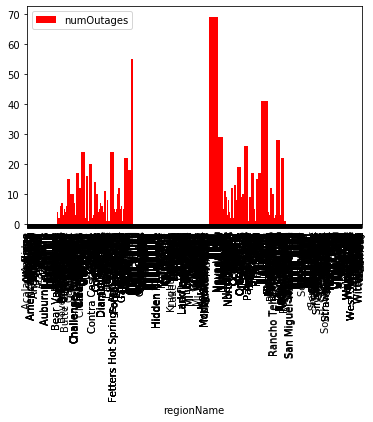

<Figure size 14400x720 with 0 Axes>

from the graph, we learn that there are too many regions to visualize.


In [17]:
# explore the dataframe
print('the shape of df is ',df.shape)
df.head()
unique_regions = df['regionName'].unique()
print('number of unique regions: ',len(unique_regions))
print('number of total regions: ', df['regionName'].size)
import matplotlib.pyplot as plt
df.plot(kind='bar',x='regionName',y='numOutages',color='red')
plt.figure(figsize=(200,10))
plt.show()
print('from the graph, we learn that there are too many regions to visualize.')

We can see that we are working with many regions and the data in its entirety is difficult to visualize. Let's try making the graph larger

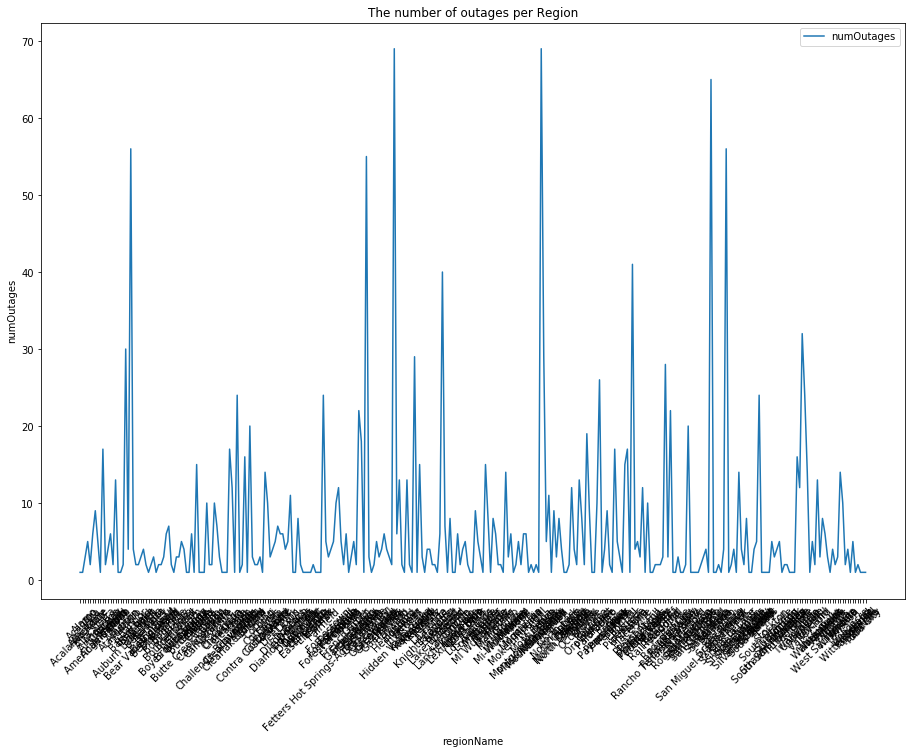

In [18]:
# plot total outages
fig4 = plt.figure()
ax4 = fig4.add_axes([.2,.2,2,2])
ax4.set_xlabel('regionName')
ax4.set_ylabel('numOutages')
ax4.set_title('The number of outages per Region')
ax4.plot(df['regionName'],df['numOutages'],label='numOutages')
plt.xticks(rotation=45)
ax4.legend()

We can investigate smaller amounts of data to visualize. Let's try a top ten graph

by limiting our regions plot to a top 10 list, we can learn more about the data.
              id  regionName  numOutages  customersAffected  latitude  \
770   2269458970  Healdsburg          69               4074  38.56966   
1106  2269458942        Napa          69               3547  38.33380   
1100  2269458942        Napa          69               3547  38.33380   
1101  2269458942        Napa          69               3547  38.33380   
1102  2269458942        Napa          69               3547  38.33380   
1103  2269458942        Napa          69               3547  38.33380   
1104  2269458942        Napa          69               3547  38.33380   
1105  2269458942        Napa          69               3547  38.33380   
1107  2269458942        Napa          69               3547  38.33380   
1149  2269458942        Napa          69               3547  38.33380   

      longitude                                            outages  
770  -122.77409  {'outageNumber': '692802', 'o

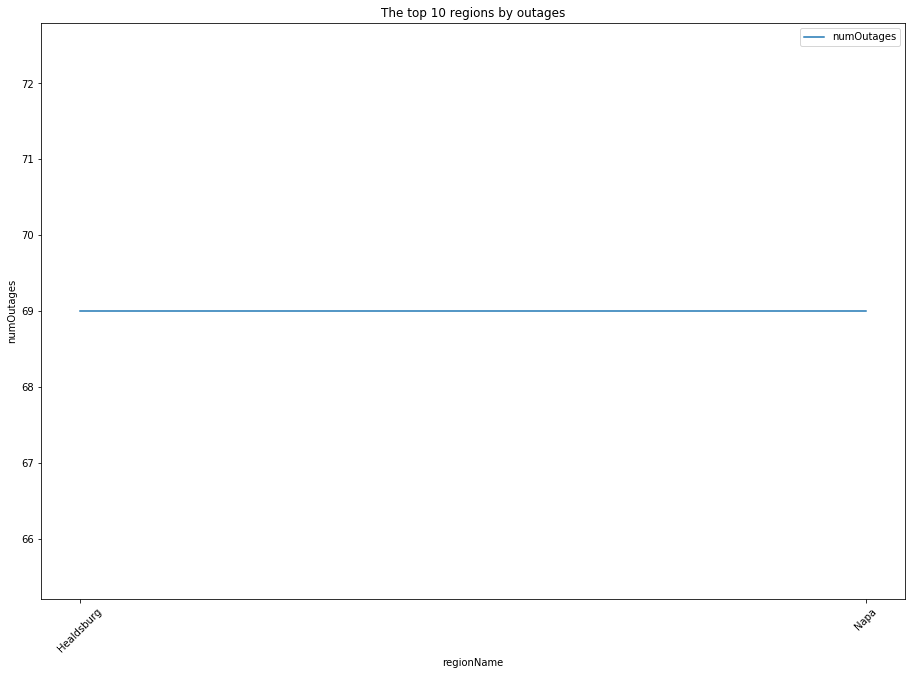

In [19]:
print('by limiting our regions plot to a top 10 list, we can learn more about the data.')
# top ten outages by region
top_ten = df.sort_values(by='numOutages', ascending=False).head(10)
fig5 = plt.figure()
ax5 = fig5.add_axes([.2,.2,2,2])
ax5.set_xlabel('regionName')
ax5.set_ylabel('numOutages')
ax5.set_title('The top 10 regions by outages')
ax5.plot(top_ten['regionName'],top_ten['numOutages'],label='numOutages')
plt.xticks(rotation=45)
ax5.legend()
print(top_ten)
print('here we learn that region data is repeated in the data set\nthe regions need to by grouped to find insights')

The data is duplicated for the regions. If we use the groupby function, we can see what each region looks like


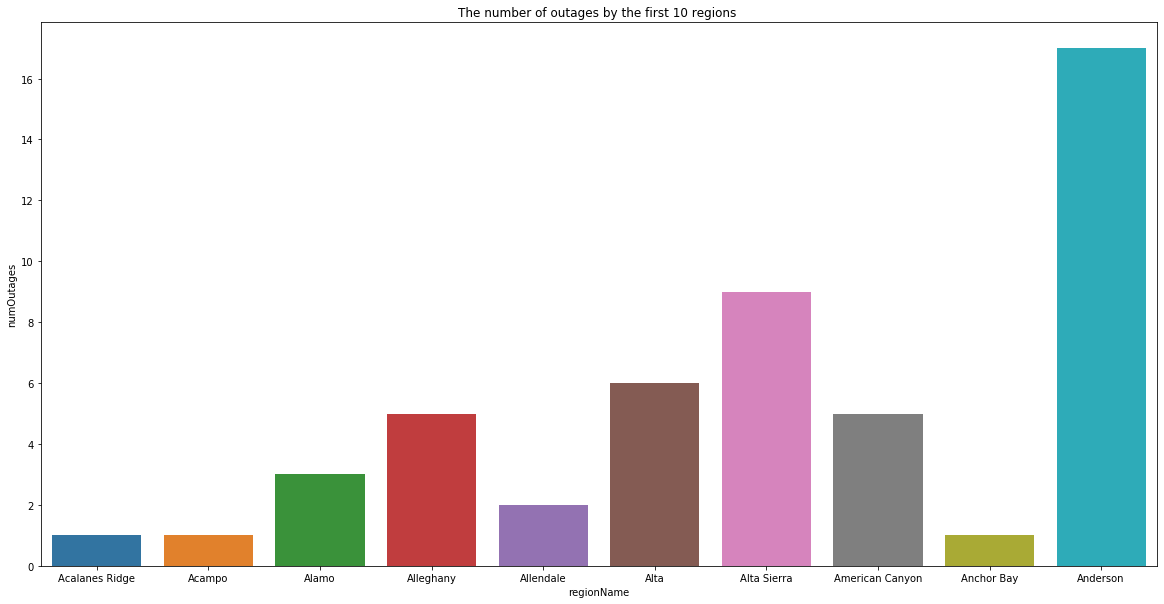

In [20]:
# We can use the groupby feature in pandas to reduce the data to single regions
# https://stackoverflow.com/questions/48909110/python-pandas-mean-and-sum-groupby-on-different-columns-at-the-same-time
plot_data = df.groupby('regionName').agg({'numOutages':'mean','customersAffected':'sum'})
fig1 = plt.figure(figsize=(20,10))
fig1 = sns.barplot(plot_data.index[0:10],plot_data['numOutages'][0:10])
fig1 = fig1.set_title('The number of outages by the first 10 regions ')

Great! Now we can look at the top regions for outages

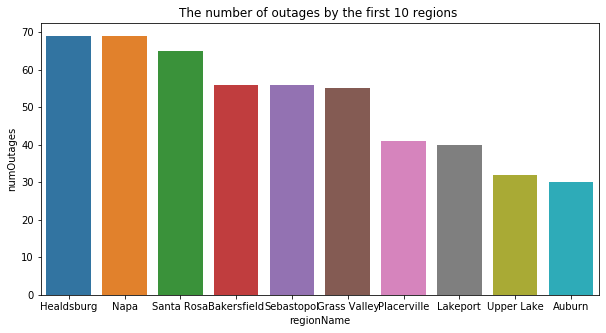

In [21]:
plot_data = plot_data.sort_values(by='numOutages', ascending=False)
fig2 = plt.figure(figsize=(10,5))
fig2 = sns.barplot(plot_data.index[0:10],plot_data['numOutages'][0:10])
fig2 = fig2.set_title('The number of outages by the first 10 regions ')

Let's investigate the number of customers affected by region

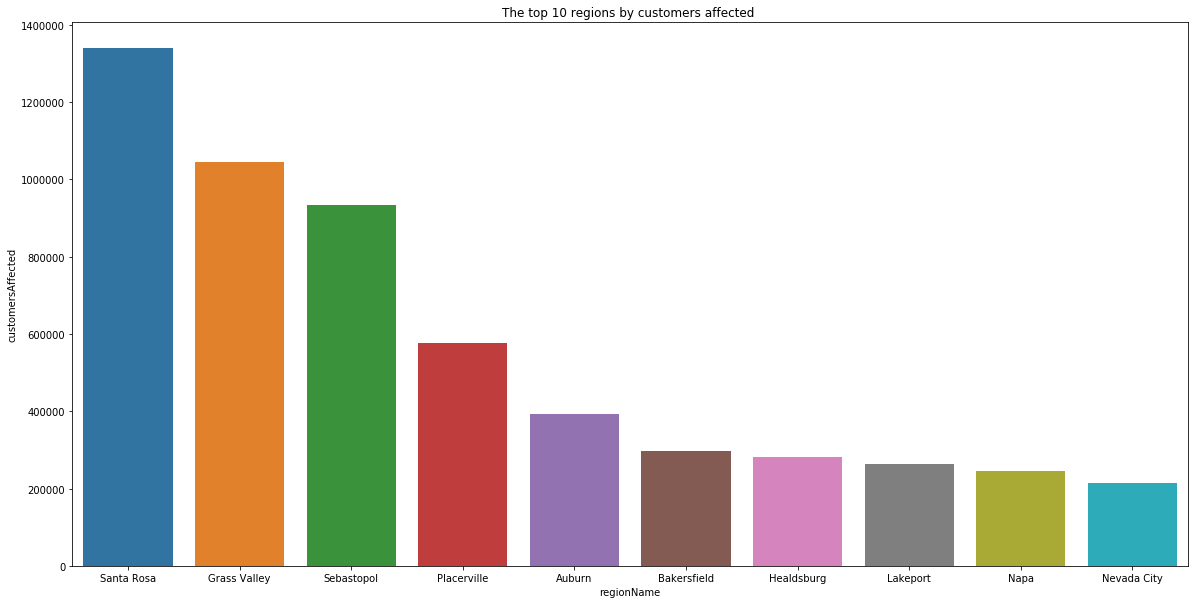

In [22]:
plot_data = plot_data.sort_values(by='customersAffected', ascending=False)
fig3 = plt.figure(figsize=(20,10))
fig3 = sns.barplot(plot_data.index[0:10],plot_data['customersAffected'][0:10])
fig3 = fig3.set_title('The top 10 regions by customers affected ')

Is it worth graphing these together? Maybe not

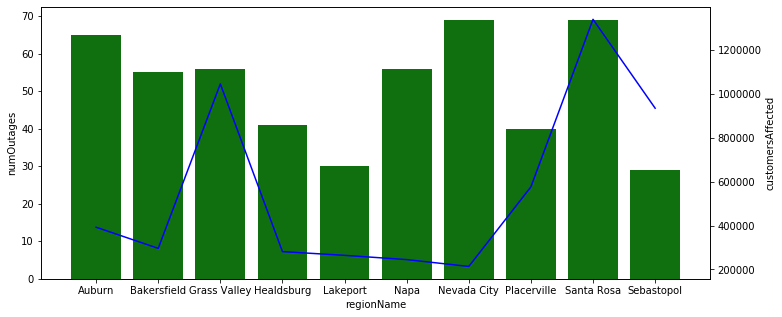

In [23]:
# https://stackoverflow.com/questions/47591650/second-y-axis-time-series-seaborn
# double plot
# needs dual axis
fig4 = plt.figure(figsize=(12,5))
fig4 = sns.barplot(x=plot_data.index[0:10], y=plot_data['numOutages'][0:10], color="g")
ax2 = plt.twinx()
sns.lineplot(x=plot_data.index[0:10], y=plot_data['customersAffected'][0:10], color="b", ax=ax2)

In [24]:
# explore outages
print('the data type in the outage column is :',type(df['outages'].iloc[1]))
t = df.loc[12,'outages']
print('an example of the data in the outage column is')
print(t)
print('the number of rows in the dataframe is \n', df.shape[0])
df_outages = pd.DataFrame({})
columns = ['outageNumber','outageStartTime','crewCurrentStatus','cause','estCustAffected','lastUpdateTime','hazardFlag',
           'latitude','longitude','outageDevices']

print('make a big dictionary')
print('loop over outages')
outage_dict = {}
for index, value in df['outages'].items():
    #print(index, value)
    outage_dict[index] = value

print('the first entry of the outage dictionary is ', outage_dict[0])

df_outages = pd.DataFrame.from_dict(outage_dict, orient='index')

# are the outage numbers unique? If so, we could use them as a primary key
print('the shape of the outage dataframe is ', df_outages.shape)
print('the number of unique outageNumber is ', len(df_outages['outageNumber'].unique()))
# since the outage number is unique, we will go back to our data cleaning and set the outageNumber to the index
#df_outages.head()

# convert data to numeric
# convert Series
df_outages['estCustAffected'] = pd.to_numeric(df_outages['estCustAffected'])
df_outages['latitude'] = df_outages['latitude'].astype(float)
df_outages['longitude'] = df_outages['longitude'].astype(float)

#replace outages in df with a index reference in the df_outages
#df['outages'] = outage_dict.keys()

the data type in the outage column is : <class 'dict'>
an example of the data in the outage column is
{'outageNumber': '690716', 'outageStartTime': '1572141660', 'crewCurrentStatus': 'PG&E has assigned a crew to assess the outage.', 'cause': 'To protect public safety, power in your area has been turned off due to extreme weather conditions with high fire danger. Power will be restored as soon as it is safe to do so.', 'estCustAffected': '146', 'lastUpdateTime': '1572449016', 'hazardFlag': '0', 'latitude': '39.20995', 'longitude': '-120.80204', 'outageDevices': [{'latitude': '39.20395', 'longitude': '-120.80495'}, {'latitude': '39.20553', 'longitude': '-120.79234'}, {'latitude': '39.21111', 'longitude': '-120.77912'}, {'latitude': '39.21368', 'longitude': '-120.77542'}, {'latitude': '39.21622', 'longitude': '-120.77368'}, {'latitude': '39.21741', 'longitude': '-120.7732'}, {'latitude': '39.22061', 'longitude': '-120.77637'}, {'latitude': '39.22111', 'longitude': '-120.7789'}, {'latitude

In [25]:
# check out the data
df_outages.head(6)

,outageNumber,outageStartTime,crewCurrentStatus,cause,estCustAffected,lastUpdateTime,hazardFlag,latitude,longitude,outageDevices,currentEtor,autoEtor,crewEta
0,694747,1572445075,PG&E has assigned a crew to assess the outage.,Unknown - PG&E will be assessing the cause.,1,1572445384,0,37.90412,-122.07907,NaN,NaN,NaN,NaN
1,693243,1572363240,PG&E is sending a repair crew to the outage lo...,Our preliminary determination is that your out...,2,1572453974,0,38.18178,-121.14801,NaN,NaN,NaN,NaN
2,693226,1572362244,PG&E has assigned a crew to assess the outage.,Unknown - PG&E will be assessing the cause.,12,1572451863,0,37.83693,-122.01996,NaN,NaN,NaN,NaN
3,692662,1572314944,PG&E has assigned a crew to assess the outage.,Unknown - PG&E will be assessing the cause.,1,1572336548,0,37.83693,-122.01996,NaN,NaN,NaN,NaN
4,693875,1572373007,PG&E is assessing the cause at the outage loca...,PG&E is investigating the cause of your outage.,40,1572451863,0,37.83540,-122.02393,"[{'latitude': '37.83305', 'longitude': '-122.0...",NaN,NaN,NaN
5,682339,1572139440,PG&E has assigned a crew to assess the outage.,"To protect public safety, power in your area h...",83,1572428868,0,39.46546,-120.84435,"[{'latitude': '39.46292', 'longitude': '-120.8...",1572750000,NaN,NaN


In [26]:
# some outages have outageDevices, which ar a list of latitude and logitudes that are slightly differenct
df_outages['outageDevices'].iloc[4]

[{'latitude': '37.83305', 'longitude': '-122.02209'},
 {'latitude': '37.83355', 'longitude': '-122.02138'},
 {'latitude': '37.83463', 'longitude': '-122.02271'},
 {'latitude': '37.83725', 'longitude': '-122.02636'},
 {'latitude': '37.83448', 'longitude': '-122.02367'}]

In [27]:
# group by the crewCurrent Status
df_outages.groupby(['crewCurrentStatus']).count()

,outageNumber,outageStartTime,cause,estCustAffected,lastUpdateTime,hazardFlag,latitude,longitude,outageDevices,currentEtor,autoEtor,crewEta
crewCurrentStatus,,,,,,,,,,,,
PG&E assessment crew is en route to the outage.,26,26,26,26,26,26,26,26,9,8,7,9
PG&E has assigned a crew to assess the outage.,1796,1796,1796,1796,1796,1796,1796,1796,1414,210,44,1
PG&E is assessing the cause at the outage location.,28,28,28,28,28,28,28,28,11,5,5,13
PG&E is sending a repair crew to the outage location.,107,107,107,107,107,107,107,107,62,37,6,2
PG&E is unable to access the affected equipment.,21,21,21,21,21,21,21,21,20,1,0,0
PG&E repair crew is en route to the outage location.,10,10,10,10,10,10,10,10,6,8,0,2
PG&E repair crew is on-site working to restore power.,23,23,23,23,23,23,23,23,11,19,0,6


In [28]:
# plot the estimated customers effected by outage number, then by outage start time
df_outages['estCustAffected'] = pd.to_numeric(df_outages['estCustAffected'])


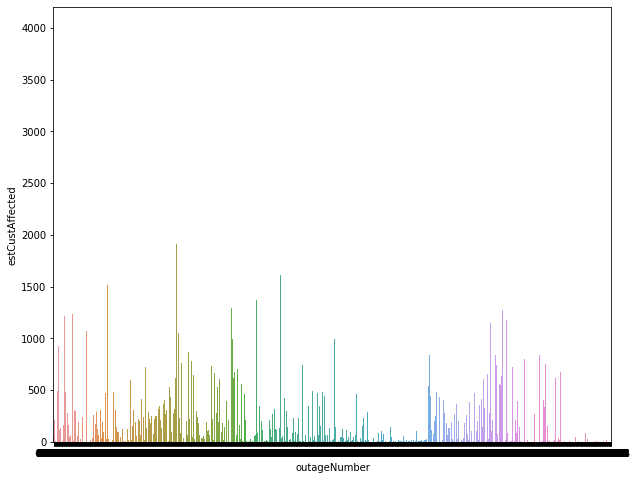

In [29]:
fig2 = plt.figure(figsize=(10,8))
fig2 = sns.barplot(df_outages['outageNumber'], df_outages['estCustAffected'])

In [30]:
# make an outage devices dataframe
df_outage_devices = pd.DataFrame({})
devices_dict = {}
j=0
for i in range(df_outages.shape[0]):
    outage_device = df_outages['outageDevices'].iloc[i]
    if i < 80000 :
        #print(type(outage_device))
        #print(outage_device)

        if isinstance(outage_device,float):
            devices_dict[j] = {'outageNumber':df_outages['outageNumber'].iloc[i],'latitude':float('nan'),'longitude':float('nan')}
            j += 1
            #print(devices)
        elif isinstance(outage_device, list):
            for item in outage_device:
                # add the outage number as a foriegn key
                item['outageNumber'] = df_outages['outageNumber'].iloc[i]
                #store the outage device
                devices_dict[j] = item
                #print(i,j, item)
                j += 1
            #print('list')
        else:
            print('unexpected data type in index ', i)
print('here is a taste of the devices dictionary ...')
for i in range(6):
    print(devices_dict[i])
    
df_outage_devices = pd.DataFrame.from_dict(devices_dict, orient='index')
df_outage_devices['latitude'] = df_outage_devices.latitude.astype(float)
df_outage_devices['longitude'] = df_outage_devices['longitude'].astype(float)
# this conversion doesnt work
#try:
#    df_outage_devices['latitude'] = pd.to_numeric[df_outage_devices['latitude']]
#except:
#    print('nothing')
print('the shape of the outage devices dataframe is ', df_outage_devices.shape)
print('here is the new dataframe of outage devices')
print(df_outage_devices.head(6))
print(type(df_outage_devices.loc[4,'latitude']))

here is a taste of the devices dictionary ...
{'outageNumber': '694747', 'latitude': nan, 'longitude': nan}
{'outageNumber': '693243', 'latitude': nan, 'longitude': nan}
{'outageNumber': '693226', 'latitude': nan, 'longitude': nan}
{'outageNumber': '692662', 'latitude': nan, 'longitude': nan}
{'latitude': '37.83305', 'longitude': '-122.02209', 'outageNumber': '693875'}
{'latitude': '37.83355', 'longitude': '-122.02138', 'outageNumber': '693875'}
the shape of the outage devices dataframe is  (13418, 3)
here is the new dataframe of outage devices
  outageNumber  latitude  longitude
0       694747       NaN        NaN
1       693243       NaN        NaN
2       693226       NaN        NaN
3       692662       NaN        NaN
4       693875  37.83305 -122.02209
5       693875  37.83355 -122.02138
<class 'numpy.float64'>


In [31]:
#https://stackoverflow.com/questions/48909110/python-pandas-mean-and-sum-groupby-on-different-columns-at-the-same-time
#df_outage_devices[df_outage_devices['outageNumber']=='693875']
df_outage_devices.groupby('outageNumber').count().sort_values(by='latitude', ascending=False).head()

,latitude,longitude
outageNumber,,
684156,22,22
683482,20,20
684422,19,19
693700,18,18
681175,18,18


In [32]:
df_outage_devices.groupby('outageNumber').agg({'latitude':'mean','longitude':'mean'}).rename(columns={'latitude':'avg latitude','longitude':'avg longitude'}).head()

,avg latitude,avg longitude
outageNumber,,
677742,38.723761,-122.891651
677913,38.643323,-122.797806
677921,38.733027,-122.915574
677954,38.700921,-122.858806
679021,38.764081,-122.849063


   outageNumber  numOccurances
0        684156             22
1        683482             20
2        684422             19
3        693700             18
4        681175             18
RangeIndex(start=0, stop=10, step=1)


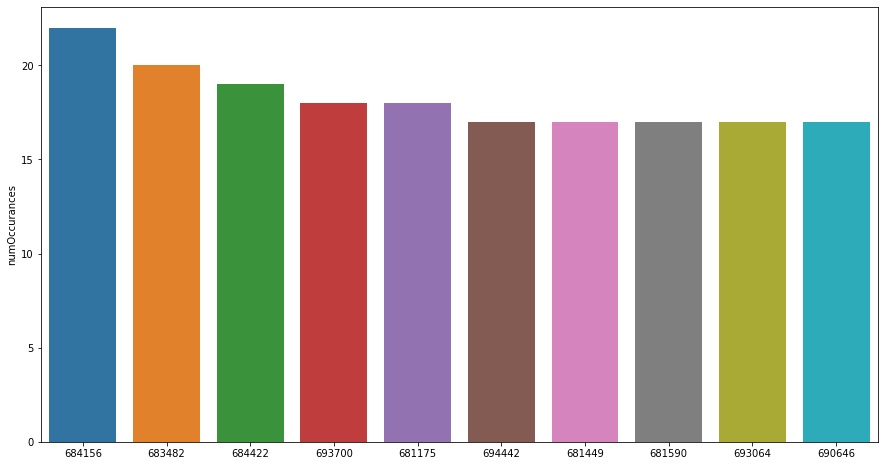

In [33]:
# https://stackoverflow.com/questions/43770507/seaborn-bar-plot-ordering
data = df_outage_devices.groupby('outageNumber').agg({'latitude':'count'}).sort_values(by='latitude',ascending=False)
data = data.rename(columns={'latitude':'numOccurances'})
data.index = data.index.astype(int)
data = data.reset_index() # needed to reset the index so that the graph would remain ordered 
print(data.head())
print(data.index[0:10])
fig6 = plt.figure(figsize=(15,8))
ax = sns.barplot(x=data.index[0:10],y=data['numOccurances'][0:10])
ax.set_xticklabels(data['outageNumber']) # jump through hoops to get the bar plot ordered by the largest to smallest
plt.show() # need to use show to hide axis text in output. Try commenting this line out and see what I mean
#sns.barplot(x=data.index[0:10],y=data['numOccurances'][0:10])

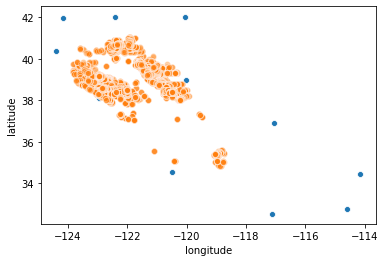

In [34]:
# https://www.bigendiandata.com/2017-06-27-Mapping_in_Jupyter/
# plot the latitude and longitude for the outages in a pseudo map
cali_points_lat = [41.948516,32.534394,32.760509,34.419965,38.964755,41.993893,34.534049,40.392856,38.114788,36.886185,42.031271]
cali_points_lon = [-124.175846,-117.128006,-114.582182,-114.153300,-120.023924,-120.052420,-120.483889,-124.391336,-122.937455,-117.065463,-122.414661]
data = df_outage_devices
#data.plot(kind='scatter',x='longitude',y='latitude',alpha=0.4)
sns.scatterplot(x=cali_points_lon,y=cali_points_lat)
sns.scatterplot(x=data['longitude'],y=data['latitude'],alpha=0.4) # alpha is the opacity
plt.show()

It looks like the PGE outages are almost entirely isolated to Northern California. It would be interesting to compare this to where the wildfires are, considering PGE has lost power due to the fires.

In [36]:
# https://www.edureka.co/community/17558/python-aws-boto3-how-do-i-read-files-from-s3-bucket
s3 = boto3.resource('s3')
bucket = s3.Bucket(bucketname)
for obj in bucket.objects.all():
    key = obj.key
    print(key)
    #body = obj.get()['Body'].read()
    
#iterating ove the bucket
files = list(my-bucket.objects.filter(Prefix='path/to/my/folder'))
obj = files[0].get()

data/
data/data_from_1572332135.4436903.txt
data/data_from_1572384650.9967704.txt
data/data_from_1572386402.4517252.txt
data/data_from_1572390002.9871469.txt
data/data_from_1572393602.674215.txt
data/data_from_1572397202.24177.txt
data/data_from_1572400855.434491.txt
data/data_from_1572404402.956938.txt
data/data_from_1572408002.4315376.txt
data/data_from_1572411602.9309971.txt
data/data_from_1572415202.650119.txt
data/data_from_1572418803.3980985.txt
data/data_from_1572422402.9312072.txt
data/data_from_1572426002.4917574.txt
data/data_from_1572429603.2126467.txt
data/data_from_1572433202.7019958.txt
data/data_from_1572436802.7815344.txt
data/data_from_1572440402.2952123.txt
data/data_from_1572444022.4434023.txt
data/data_from_1572447603.0133817.txt
data/data_from_1572451202.4824595.txt
data/data_from_1572454803.044927.txt
data/data_from_1572458402.6299489.txt
data/data_from_1572462003.179669.txt
data/data_from_1572465602.5929303.txt
data/data_from_1572469222.3300884.txt
data/data_from

NameError: name 'my' is not defined